# Treasure Hunters Inc.

The purpose of this assignment is to explore the reinforcement learning paradigm for solving (navigating) a map like environment.

### Sec-1.1: Description of Map
---
The map is conceived of as a maze in which walls between cells serve the purpose of **obstacles**. There is **treasure** hidden in one of the cells of the maze. _The goal of **reinforcement learning agent** is to find the best path to the treasure from any cell in the maze while avoiding the obstacles._

In the code below, the maze is enclosed in the ``` Board Class```. It is described as a partial adjacency matrix of the cells which are reachable from each other i.e., not separated by a wall. In addition to the cells, the board class contains the location of the cell in which treasure is hidden.

### Sec-1.2: Q-Learning Strategy
---
We use the Q-learning approach to design an AI agent which can solve the board. In our design, the behavior of the Q-agent is governed by two metrics; as is standard in Q-learning pardigm:
  - Imediate **reward** associated with an action
  - **Quality** of the action; dictated by the history of moves which follow the action - learnt by the agent through experience

In the agent class coded below, the class private matrices **R** and **Q** serve as the two metrics described above repectively.

The agent learns to navigate the maze iteratively via the ```train ()``` function. During training, the quality matrix ```Q``` is updated to gather **experience** by the agent using the **Bellman Equation**.

Once the agent has learnt to navigate the maze, the game is played by giving an arbitrary start point to the agent and checking if the agent can successfully find the treasure from that starting point.

## Sec-2: Code
---
Given the complexity of this assignmet, the code is amply commented to help in understanding the flow. The ```Board Class``` contains description of the environment; including the definition of the maze, the obstacles and the location of the treasure. The ```Agent Class``` encodes the behavior of the Q-Learning agent and the meat of the learning algorithm itself.

In [1]:
# Only the following two external libraries are used by our learning alogrithm
import numpy as np
import random

### Sec-2.1: Board Class
---
The board class describes the environment in which game is played.

In [2]:
class Board:
    def __init__ (self, maze, goal):
        # The maze is described as a partial adjacency matrix;
        # where each cell index contains the location of the
        # next cell which is accessible from it
        self.maze = maze
        
        # Goal annotates the location of the treasure in the
        # board. Note that this location is fixed for a given
        # setting of the board
        self.goal = goal

    def get_maze (self):
        return self.maze

    def get_goal (self):
        return self.goal

### Sec-2.2: Agent Class
---
The agent class contain the meat of the Q-learning algorithm. This class is fairly large but we have amply commented the code to aide in understanding.

The most significant part of the agent is the **policies** of the game which are encoded in the agent's behavior via the reward (**R**) matrix. For sake of clarity, these policies are described below in detail.

#### Sec-2.2.1: Game Policies
**R** matrix stands for *rewards*. It specifies the reward for visiting
every state from every other state; hence it is an 'N x N' (N = total number of states) matrix.
It is the most important matrix for specifying the "rules" of the game
and consequently in dictating the behavior of the agent when it plays
the game. For the assignment at hand, following simple rules are
implemented:

  - **Policy-1**: If a state can be visited from a given state, the reward is
slightly negative i.e., the reward (r) for a "legitimate" move in our
game is slightly negative (-1 < r < 0).

  - **Policy-2**: If a state cannot be visited from a given state (i.e., illegal
move), the reward is maximally negative. In the semantics of our game,
this is indicated by value '-1'.

  - **Policy-3**: The reward for reaching the final state (i.e., goal) is
maximally positive; indicated by value '1'.

The **rationale for assigning slightly negative reward** to a legitimate move
is to discourage the tendency to make unnecessary moves. With this
policy, a good agent should be able to find the shortest sequence of
moves for reaching the goal.

Also, **to discourage the agent from staying in the same state**, the move
from a state to itself is considered an illegal move i.e., it is
encoded with '-1' reward.

#### Sec-2.2.2: Training Strategy
  - At the begining of each training cycle, the agent is placed in a
   randomly selected cell of the maze.
  - The agent randomly selects a next possible state from the given
   state.
    - From the chosen next state, the "history" of max. total reward which
         can be obtained from that state is calculated. This is done by
         performing a lookup in the Q matrix.
    - Using the given state, a possible next state and the maximum reward
         obtainable from the next state, the Q matrix is updated using the
         Bellman equation:
         ```Q [state][nextState] = R [state][nextState] + gamma * max_quality_next_state```
    - Current state is updated to next state and the above strategy
         is continued until the end state is reached.
  - At the end of each training cycle, the improvement in the Q matrix
   is measured. Training is terminated when a cycle does not yeild
   signficant improvement.

Once training is complete, the agent can be used to navigate the maze
on its own given arbitrary starting points.

In [3]:
# A global variable to dictate the exploration count for the Q-agent
EXPLORE_COUNT = 10

class QLearn:
    def __init__ (self, board):
        self.R = None
        self.Q = None
        self.maze = board.get_maze ()
        self.rows = len (self.maze)
        self.cols = len (self.maze [0])
        self.states = self.rows * self.cols
        self.treasure = board.get_goal ()
        self.endState = self.cell_to_state (self.treasure)

        # The following hash table will contain every state the can be
        # "legally" visited from a given state. It will be keyed with the
        # state-value and will contain list of next state-values for the
        # given state
        self.nextStates = {}

        self.initialize ()
        return

    def initialize (self):
        self.__initQ ()
        self.__initR ()
        return

    def __initQ (self):
        ''' Q matrix contains history of visiting every state from every other
        state. In reinforcement learning, it serves the purpose of tracking the
        "Quality" of making a move given the history of play. Provided that we
        have 'N' states, Q matrix will contain 'N x N' elements. Here we
        intiialize all these elements to zero since our agent has not played
        any games yet and hence it has no hisotry of moves.'''
        
        self.Q = np.zeros ((self.states, self.states))
        return

    def __initR (self):
        ''' R matrix stands for rewards. It specifies the reward for visiting
        every state from every other state; hence it is also an 'N x N' matrix.
        It is the most important matrix for specifying the "rules" of the game
        and consequently in dictating the behavior of the agent when it plays
        the game. These rules are described in the documentation in detail.'''

        # Initialize R matrix for all states with '-1'; indicating that
        # no other state is accessbile from any state
        self.R = np.full ((self.states, self.states), -1, dtype = np.float)

        for x in range (self.rows):
            for y in range (self.cols):
                cell = (x, y)
                state = self.cell_to_state (cell)
                adjCell = self.maze [x][y]
                adjState = self.cell_to_state (adjCell)

                if state == adjState:
                    continue

                self.link_states (state, adjState)

                # If the cell next to us is the goal cell, the reward is max.
                if adjState == self.endState:
                    self.R [state][adjState] = 1.0
                    continue

                # Same check as above but from the goal cell's PoV
                if state == self.endState:
                    self.R [adjState][state] = 1.0
                    continue

                # States are reachable from each other
                self.R [state][adjState] = -0.1
                self.R [adjState][state] = -0.1

        # We don't want to come out of end state so we reward the action of
        # 'staying in the end state' with the maximum possible value
        self.R [self.endState][self.endState] = 1.0

        return

    def train (self, gamma = 0.8, improvement_threshold = 0.001):
        ''' The purpose of train function is to use reinforcement learning to
        train the AI for navigating the maze in the best possible way as per
        the rules of the game. The training strategy is described in detail
        in the documentation'''
        print "[STATUS] Training Q-agent..."
        epoch = 0

        while True:
            epoch += 1
            prevQ = np.copy (self.Q)

            for i in range (EXPLORE_COUNT):
                state = random.choice (range (self.states - 1))

                while (state != self.endState):
                    # Exploration
                    n_state = random.choice (self.nextStates [state])

                    # Exploitation
                    max_quality_next_state = -1
                    for n_n_state in self.nextStates [n_state]:
                        max_quality_next_state = max (max_quality_next_state, self.Q [n_state][n_n_state])

                    # Update quality matrix
                    self.Q [state][n_state] = self.R [state][n_state] + (gamma * max_quality_next_state)

                    # Move to next state
                    state = n_state
            
            # Normalize quality matrix
            self.Q = self.Q / np.max (np.abs (self.Q))
            improvement = np.sum (np.abs (self.Q - prevQ))

            print "  [TRAINING] Epoch: %2d | Improvement: %.3f" % (epoch, improvement)

            if improvement < improvement_threshold:
                break

        print "[STATUS] Training Complete!"
        return

    def play (self, start):
        ''' The purpose of this function is to use a trained Q-agent for
        solving the maze puzzle. The agent is given a starting point and it
        must navigate the maze to find the best path to the goal i.e., treasure
        while avoiding any obstacles. It is assumed that the maze is
        solvable.'''
        path = [start]
        curPosition = start

        while (path [-1] != self.treasure and len (path) < self.states):
            nextCell = self.make_best_move (curPosition)
            path.append (nextCell)
            curPosition = nextCell

        return path

    def make_best_move (self, cell):
        state = self.cell_to_state (cell)
        qList = self.Q [state]
        possibleNextStates = self.nextStates [state]

        bestNextState = possibleNextStates [0]
        bestQ = qList [bestNextState]

        for pState in possibleNextStates:
            stateQ = qList [pState]

            if stateQ > bestQ:
                bestNextState = pState
                bestQ = stateQ

        nextCell = self.state_to_cell (bestNextState)

        return nextCell

    def link_states (self, state, nextState):
        if state not in self.nextStates.keys ():
            self.nextStates [state] = []

        if nextState not in self.nextStates.keys ():
            self.nextStates [nextState] = []

        self.nextStates [state].append (nextState)
        self.nextStates [nextState].append (state)

        return

    def cell_to_state (self, cell):
        state = cell [0] * self.rows + cell [1]
        return state
    
    def state_to_cell (self, state):
        x = state // self.rows
        y = state % self.rows
        cell = (x, y)
        return cell

## Sec-3: Demonstration
---
In this section, we demonstrate our learning algroithm by using it to solve a sample map.

### Sec-3.1: An External Module for Visualizing the Game
We are using an external module (please see **ACKNOWLEDGMENT** for source) for visualizing the board. In the gist below, a helper function is written to achieve this goal.

In [4]:
# This file contains the external module that
# we use for visualizing the board
import painter
import scipy.misc as smp

# A very simple helper function for using the paint module
# for visualizing the maze
def visualize_board (board, start = None, path = None):
    paint = painter.Paint (board.maze, board.goal, start, path)
    pixels = paint.generate_image ()
    image = smp.toimage (pixels)
    
    return image

#### Sec-3.2.1: Game with 3x3 Board, 4 Obstacles and Hidden Treasure
The initial setting of the board can be seen in the image following the code below. The **treasure** is annotated by the **green square**, the **obstacles** are visualized as **black walls**.

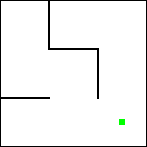

In [5]:
maze = [[(0, 0), (0, 2), (1, 2)],
        [(0, 0), (1, 0), (2, 2)],
        [(2, 1), (1, 1), (2, 1)]]

treasure = (2, 2)

board = Board (maze, treasure)
visualize_board (board)

#### Sec-3.2.2: Training the Q-Agent and Solving the Map
In the following code, the reinforcement learning agent is trained on the map and then the trained agent is used to solve the map i.e., find the path to the treasure from a given starting point while avoiding the obstacles.

In [6]:
# Create and train the agent and use it to play the game
agent = QLearn (board)
agent.train ()
startPoint = (0, 0)
path = agent.play (startPoint)

print
print "Optimal Path to the Treasure: ", path

[STATUS] Training Q-agent...
  [TRAINING] Epoch:  1 | Improvement: 7.499
  [TRAINING] Epoch:  2 | Improvement: 0.410
  [TRAINING] Epoch:  3 | Improvement: 0.000
[STATUS] Training Complete!

Optimal Path to the Treasure:  [(0, 0), (1, 0), (1, 1), (2, 1), (2, 2)]


#### Sec-3.2.3: Visualized the Solved Map
The solved map with the path chosen by the agent is shown below. The **start point** is shows as a **red square** and **the path** consists of blocks marked as **grey squares** connecting the start point with the treasure.

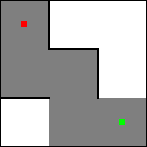

In [7]:
visualize_board (board, startPoint, path)

## Sec-4: Conclusion
---
It can be seen that **our trained agent is doing an excellent job in finding the treasure in the map while avoiding obstacles.** The path selected by our agent is the same as the one that would be chosen by a human player in solving this map.

**ACKNOWLEDGMENT**: The board visualization module was copied in entirety from the following source:
https://github.com/mitchellspryn/QLearningMazeSolver/blob/master/maze.py

We also consulted the same source for understanding the Q-learning algorithm.

Despite help from the source mentioned above, the code written in this notebook was coded entirely by us. **We took the understanding we developed from the cited source to develop Q-learning pseudo-code and then wrote the code in this notebook from scratch.**

This has been the **toughest and most demanding** assignment that we have done in this course. **We have spent > 15 hours for doing this assignment.**